In [152]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [153]:
#자연발생 클러스터링(민원 단계 컬럼 생성)
from jenkspy import JenksNaturalBreaks

parks_df = pd.read_csv("src/RF_parksdf_holi.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")

# 1) IQR 계산
Q1 = parks_df["complaints_r300"].quantile(0.25)
Q3 = parks_df["complaints_r300"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2) 이상치 제거
outliers = parks_df[
    (parks_df["complaints_r300"] < lower_bound) |
    (parks_df["complaints_r300"] > upper_bound)
].copy()

parks_df = parks_df.drop(outliers.index).copy()

# 3) 필터된 데이터로 Jenks 적용
i = 3
breaks = JenksNaturalBreaks(n_classes=i)
breaks.fit(parks_df["complaints_r300"])
print("경계값:", breaks.breaks_)

# 4) 레이블 부여
parks_df["complaint_level"] = pd.cut(
    parks_df["complaints_r300"],
    bins=breaks.breaks_,
    labels=range(i),
    include_lowest=True
)
parks_df["complaint_level"].value_counts()

경계값: [0, 275, 617, 1164]


complaint_level
0    774
1    485
2    219
Name: count, dtype: int64

=== 이상치 그룹 기술통계 ===
       total_parking_spaces  base_parking_fee  base_parking_time  \
count            147.000000        147.000000         147.000000   
mean              40.748299        375.612245          11.836735   
std               66.469052        308.805641          17.172390   
min                1.000000          0.000000           0.000000   
25%                1.000000        200.000000           5.000000   
50%               19.000000        250.000000           5.000000   
75%               59.000000        500.000000           5.000000   
max              491.000000       1500.000000          60.000000   

       additional_unit_fee  additional_unit_time   cctv_r300    bus_r300  
count           147.000000            147.000000  147.000000  147.000000  
mean            303.163265              7.278912    4.612245    9.394558  
std             232.896504              8.743516    2.950387    5.204789  
min               0.000000              0.000000    0.000000    0.0

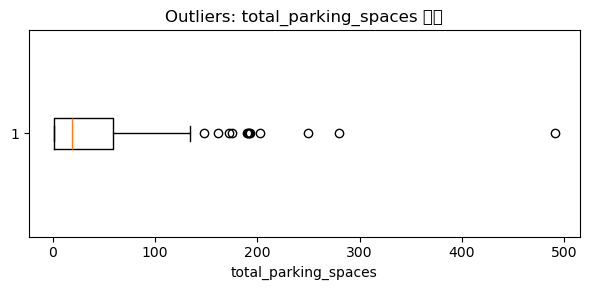

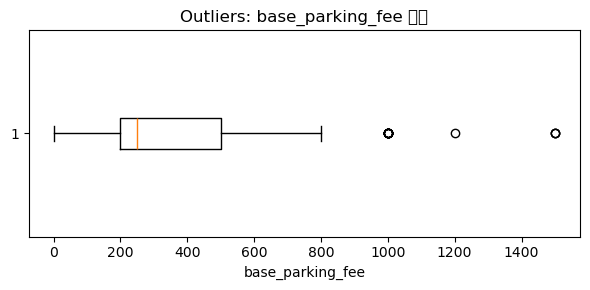

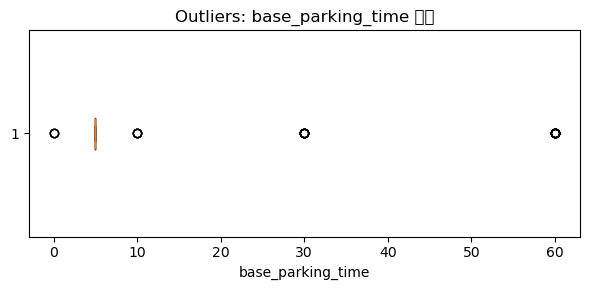

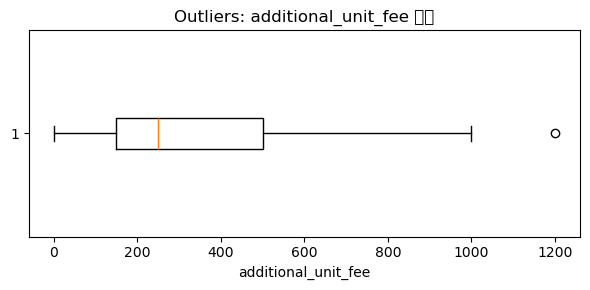

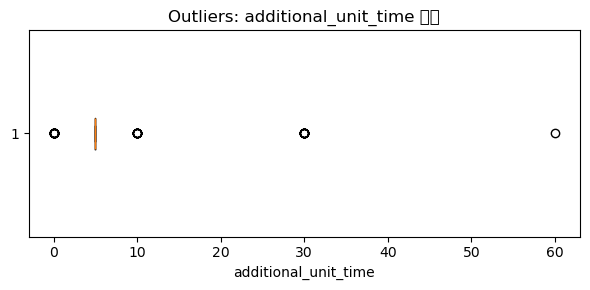

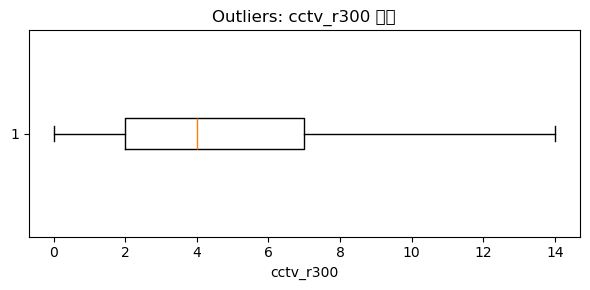

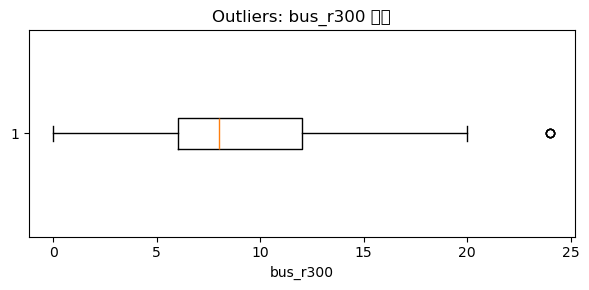


=== Outliers 내부 서브클러스터 평균 프로파일 ===
            total_parking_spaces  base_parking_fee  base_parking_time  \
subcluster                                                              
0                      27.066667        732.888889          23.333333   
1                      46.784314        217.990196           6.764706   

            additional_unit_fee  additional_unit_time  cctv_r300   bus_r300  
subcluster                                                                   
0                    575.111111             14.111111   5.711111  10.288889  
1                    183.186275              4.264706   4.127451   9.000000  

=== Subcluster별 샘플 수 ===
subcluster
1    102
0     45
Name: count, dtype: int64


In [154]:
# ─── 1) 이상치(outliers) 그룹 복사 ──────────────────────────────────────────
df_out = outliers.copy()

# ─── 2) 분석에 사용할 피처 리스트 정의 ───────────────────────────────────────
features = [
    "total_parking_spaces",
    "base_parking_fee",
    "base_parking_time",
    "additional_unit_fee",
    "additional_unit_time",
    "cctv_r300",
    "bus_r300"
    # 필요하면 인구밀도, 상권지수 등 외부 요인 컬럼 추가
]

# ─── 3) 이상치 그룹 기술통계 출력 ───────────────────────────────────────────
print("=== 이상치 그룹 기술통계 ===")
print(df_out[features].describe())

# ─── 4) 각 피처 분포 시각화 (박스플롯) ──────────────────────────────────────
import matplotlib.pyplot as plt

for col in features:
    plt.figure(figsize=(6,3))
    plt.boxplot(df_out[col].dropna(), vert=False)
    plt.title(f"Outliers: {col} 분포")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# ─── 5) 이상치 그룹 내부 클러스터링 (K-Means 예시) ──────────────────────────
from sklearn.cluster import KMeans

# 클러스터 개수 설정 (예: 2)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df_out["subcluster"] = kmeans.fit_predict(df_out[features])

# 서브클러스터별 평균 프로파일 확인
print("\n=== Outliers 내부 서브클러스터 평균 프로파일 ===")
print(df_out.groupby("subcluster")[features].mean())

# ─── 6) 서브클러스터별 샘플 개수 확인 ────────────────────────────────────
print("\n=== Subcluster별 샘플 수 ===")
print(df_out["subcluster"].value_counts())


In [155]:
print(parks_df.columns)

Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Holiday_paid', 'Holiday_operatingHours', 'lon',
       'lat', 'zoning_encoded', 'start_sin', 'start_cos', 'end_sin', 'end_cos',
       'complaint_level'],
      dtype='object')


In [156]:
'''# KMeans 기반 클러스터링

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

parks_df = pd.read_csv("src/RF_parksdf_week.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")
parks_df.columns

# 1) IQR 계산
Q1 = parks_df["complaints_r300"].quantile(0.25)
Q3 = parks_df["complaints_r300"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2) 이상치 제거
parks_df = parks_df[
    (parks_df["complaints_r300"] >= lower_bound) &
    (parks_df["complaints_r300"] <= upper_bound)
].copy()

k = 3

X = parks_df["complaints_r300"].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_.flatten()
sorted_idx = np.argsort(centers)
label_map = {old: new for new, old in enumerate(sorted_idx)}
sorted_labels = np.vectorize(label_map.get)(clusters)

parks_df["complaint_level"] = sorted_labels

parks_df["complaint_level"].value_counts().sort_index()
'''

'# KMeans 기반 클러스터링\n\nfrom sklearn.cluster import KMeans\nimport numpy as np\nimport pandas as pd\n\nparks_df = pd.read_csv("src/RF_parksdf_week.csv")\n#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")\n#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")\nparks_df.columns\n\n# 1) IQR 계산\nQ1 = parks_df["complaints_r300"].quantile(0.25)\nQ3 = parks_df["complaints_r300"].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# 2) 이상치 제거\nparks_df = parks_df[\n    (parks_df["complaints_r300"] >= lower_bound) &\n    (parks_df["complaints_r300"] <= upper_bound)\n].copy()\n\nk = 3\n\nX = parks_df["complaints_r300"].values.reshape(-1, 1)\n\nkmeans = KMeans(n_clusters=k, random_state=0)\nclusters = kmeans.fit_predict(X)\n\ncenters = kmeans.cluster_centers_.flatten()\nsorted_idx = np.argsort(centers)\nlabel_map = {old: new for new, old in enumerate(sorted_idx)}\nsorted_labels = np.vectorize(label_map.get)(clusters)\n\nparks_df["complaint_level"] = sorted_labe

In [157]:
#범주형 변수의 label을 [0,1]로 변환
from sklearn.preprocessing import LabelEncoder

le_dict = {}

for col in ["parking_type", "operation_type", "Weekday_paid", "Saturday_paid", "Holiday_paid"]:
    if col in parks_df.columns:  # ✅ 존재하는 경우에만 처리
        le = LabelEncoder()
        parks_df[col] = le.fit_transform(parks_df[col])
        le_dict[col] = le

# 예시: parking_type의 범주와 정수 매핑 확인
for col in le_dict:
    print(f"{col}: {list(le_dict[col].classes_)}")

# [0, 1, 2, ...] 순서로 classes_에 저장됨
#['NS', 'NW'] -> [0,1]
#[1, 3] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]

parking_type: ['NS', 'NW']
operation_type: [1, 3]
Holiday_paid: ['N', 'Y']


In [158]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# 0) 데이터 준비axis=
X = parks_df.drop(["complaints_r300", "complaint_level", "address", "lat", "lon",
                   "base_parking_fee", "base_parking_time", "additional_unit_fee", "additional_unit_time", "zoning_encoded"], axis=1)
y = parks_df["complaint_level"]

# 1) 80%를 train+val, 20%를 test로 분리 (stratify 유지)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) train_val(80%) 중 12.5%를 val로 → 전체 비율 10%, train은 70%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.125,    # 0.8 * 0.125 = 0.1
    stratify=y_train_val,
    random_state=42
)

# 3) 훈련셋에서만 RandomForest로 피처 중요도 계산
rf_fs = RandomForestClassifier(random_state=0)
rf_fs.fit(X_train, y_train)

importances = pd.Series(rf_fs.feature_importances_, index=X_train.columns)
top10 = importances.nlargest(10).index.tolist()
print("선택된 상위 10개 피처:", top10)

if 'start_sin' in top10 and 'start_cos' not in top10:
    top10.append('start_cos')
if 'start_cos' in top10 and 'start_sin' not in top10:
    top10.append('start_sin')
# 이렇게 하면 둘이 반드시 함께 들어감


# 4) 선택된 피처로 데이터 재정의
X_train_sel = X_train[top10]
X_val_sel   = X_val[top10]
X_test_sel  = X_test[top10]

# 5) 최종 모델 학습 & 평가
rf = RandomForestClassifier(
    random_state=0,
    class_weight="balanced"   # 클래스 불균형 보정
)
rf.fit(X_train_sel, y_train)

val_pred  = rf.predict(X_val_sel)
test_pred = rf.predict(X_test_sel)

print("Validation 정확도: {:.4f}".format(accuracy_score(y_val, val_pred)))
print("Test 정확도      : {:.4f}".format(accuracy_score(y_test, test_pred)))


선택된 상위 10개 피처: ['bus_r300', 'total_parking_spaces', 'cctv_r300', 'fee1H', 'parking_type', 'operation_type', 'Holiday_paid', 'Holiday_operatingHours', 'end_cos', 'end_sin']
Validation 정확도: 0.6824
Test 정확도      : 0.6959


In [159]:
# Accuracy 분석

from sklearn.metrics import classification_report, accuracy_score

print("Complaint Level (Kmeans) Classification Accuracy:", round(accuracy_score(y_test, test_pred), 3))
print(classification_report(y_test, test_pred, target_names=['Low', 'Mid', 'High']))

Complaint Level (Kmeans) Classification Accuracy: 0.696
              precision    recall  f1-score   support

         Low       0.75      0.83      0.79       155
         Mid       0.59      0.59      0.59        97
        High       0.72      0.48      0.58        44

    accuracy                           0.70       296
   macro avg       0.69      0.63      0.65       296
weighted avg       0.69      0.70      0.69       296



In [160]:
importances = rf.feature_importances_
feature_names = top10  # DataFrame에서 feature 이름 추출

# 중요도 표 만들기
importance_table = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_table


,feature,importance
1,total_parking_spaces,0.250064
0,bus_r300,0.231978
2,cctv_r300,0.180748
3,fee1H,0.170962
5,operation_type,0.033559
9,end_sin,0.027834
7,Holiday_operatingHours,0.027492
4,parking_type,0.027356
8,end_cos,0.025384
6,Holiday_paid,0.024624


In [161]:
import numpy as np
import pandas as pd
import shap

# ── 1) 기존 mean_abs_shap 계산 (axis=0 으로 피처별 평균 절댓값 SHAP) ─────
explainer = shap.TreeExplainer(rf)
shap_vals = explainer.shap_values(X_train_sel)

mean_abs_shap = pd.DataFrame({
    f'class_{cls}': np.abs(shap_vals[cls]).mean(axis=1)
    for cls in range(len(shap_vals))
}, index=top10)

print(mean_abs_shap.index)

# ── 2) start_time, end_time 그룹 중요도 (Euclidean norm) 계산 ──────────
for cls in mean_abs_shap.columns:
    # start_time
    # s_sin = mean_abs_shap.loc['start_sin', cls]
    # s_cos = mean_abs_shap.loc['start_cos', cls]
    # mean_abs_shap.loc['start_time', cls] = np.sqrt(s_sin**2 + s_cos**2)
    # end_time
    e_sin = mean_abs_shap.loc['end_sin', cls]
    e_cos = mean_abs_shap.loc['end_cos', cls]
    mean_abs_shap.loc['end_time', cls] = np.sqrt(e_sin**2 + e_cos**2)

# ── 3) sin/cos 개별 행 제거하여 그룹화된 DataFrame 구성 ────────────────
grouped_shap = mean_abs_shap.drop(
    ['end_sin','end_cos'],
    axis=0
)

# ── 4) 클래스별 상위 N개 피처 출력 ──────────────────────────────────
top_n = 5
for cls in grouped_shap.columns:
    print(f"\n▶ {cls} 기여도 상위 {top_n}개 피처")
    print(grouped_shap[cls].sort_values(ascending=False).head(top_n))


Index(['bus_r300', 'total_parking_spaces', 'cctv_r300', 'fee1H',
       'parking_type', 'operation_type', 'Holiday_paid',
       'Holiday_operatingHours', 'end_cos', 'end_sin'],
      dtype='object')

▶ class_0 기여도 상위 5개 피처
total_parking_spaces    0.221350
cctv_r300               0.076559
bus_r300                0.067016
fee1H                   0.056962
operation_type          0.009872
Name: class_0, dtype: float64

▶ class_1 기여도 상위 5개 피처
total_parking_spaces    0.142970
bus_r300                0.043106
fee1H                   0.040249
cctv_r300               0.036817
Holiday_paid            0.031278
Name: class_1, dtype: float64

▶ class_2 기여도 상위 5개 피처
total_parking_spaces    0.107791
fee1H                   0.087541
bus_r300                0.071648
cctv_r300               0.041198
operation_type          0.018939
Name: class_2, dtype: float64

▶ class_3 기여도 상위 5개 피처
Holiday_operatingHours    0.070932
total_parking_spaces      0.053015
cctv_r300                 0.041505
operation_type

In [162]:
'''
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('gradient boosting 정확도: {:.4f}'.format(accuracy))
'''

"\n# gradient boosting\nfrom sklearn.ensemble import GradientBoostingClassifier\n\ngb = GradientBoostingClassifier(random_state=0)\ngb.fit(X_train, y_train)\npred = gb.predict(X_test)\naccuracy = accuracy_score(y_test, pred)\nprint('gradient boosting 정확도: {:.4f}'.format(accuracy))\n"

In [163]:
## 행정동별 분석

In [164]:
from sklearn.metrics import mean_squared_error
import pandas as pd
pd.set_option('display.max_rows', None)

# 여기 요일타입에 따라 바꿔야 됩니다!!
dong_parks_df = pd.read_csv("src/dongParks_Holiday.csv")
dong_parks_df

# dong_parks_df의 feature 컬럼만 추출 (dong 이름 등 식별자 제외)
# 모델이 학습할 때 사용한 feature 리스트
model_features = list(rf.feature_names_in_)

# dong_parks_df에서 해당 컬럼만 추출
X_dong = dong_parks_df[model_features]
# 동별 민원 수준 예측
dong_parks_df['predicted_complaints'] = rf.predict(X_dong)

# 그룹별 동 이름 추출
high_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 2]['dong']
mid_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 1]['dong']
low_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 0]['dong']

# 각 그룹을 DataFrame으로 변환 (인덱스 리셋)
high_df = pd.DataFrame({'High 민원': high_dong.reset_index(drop=True)})
mid_df = pd.DataFrame({'Mid 민원': mid_dong.reset_index(drop=True)})
low_df = pd.DataFrame({'Low 민원': low_dong.reset_index(drop=True)})

# 길이가 다른 경우도 맞춰서 하나의 표로 합치기
dong_table = pd.concat([high_df, mid_df, low_df], axis=1)

from IPython.display import display
display(dong_table.head())

,High 민원,Mid 민원,Low 민원
0,고덕2동,가락본동,가리봉동
1,구산동,가양2동,가산동
2,군자동,강일동,가양1동
3,대림2동,개봉1동,가양3동
4,명동,거여2동,갈현1동


In [165]:
import pandas as pd

pd.Series(rf.feature_importances_, index=X_dong.columns).sort_values(ascending=False)

total_parking_spaces      0.250064
bus_r300                  0.231978
cctv_r300                 0.180748
fee1H                     0.170962
operation_type            0.033559
end_sin                   0.027834
Holiday_operatingHours    0.027492
parking_type              0.027356
end_cos                   0.025384
Holiday_paid              0.024624
dtype: float64

In [166]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_dong),
    columns=X_dong.columns
)

'''
# 정규화 수행
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_dong), columns=X_dong.columns)
'''

# 정규화된 데이터 기준으로 영향력 큰 feature 추정
importances = rf.feature_importances_
dong_parks_df['top_feature'] = X_scaled.apply(
    lambda row: row.index[np.argmax(np.abs(row.values * importances))],
    axis=1
)

# 결과 출력
solution_table = dong_parks_df[['dong', 'predicted_complaints', 'top_feature']]
display(solution_table.head())

# 민원 수준별 요약
summary = solution_table.groupby('predicted_complaints')['top_feature'].value_counts()
print(summary)


,dong,predicted_complaints,top_feature
0,가락본동,1,cctv_r300
1,가리봉동,0,total_parking_spaces
2,가산동,0,bus_r300
3,가양1동,0,total_parking_spaces
4,가양2동,1,bus_r300


predicted_complaints  top_feature         
0                     bus_r300                48
                      total_parking_spaces    47
                      fee1H                   38
                      end_cos                 32
                      cctv_r300               31
1                     fee1H                   30
                      bus_r300                22
                      cctv_r300               21
                      total_parking_spaces    18
                      end_cos                  2
2                     bus_r300                 6
                      cctv_r300                6
                      fee1H                    6
                      total_parking_spaces     6
Name: count, dtype: int64


In [167]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1) 행정동 경계 불러오기 (EPSG:5179)
dong_boundaries = (
    gpd.read_file("src/dong_boundary.shp")
       .rename(columns={"ADM_NM":"dong"})
)

# 3) 주소에서 ‘○○동’ 부분만 추출해 두기
parks_df['addr_dong'] = parks_df['address'].str.extract(r'^\S+\s+(\S+동)')[0]

# 4) GeoDataFrame 생성 (위경도 → EPSG:4326 지정)
geometry = [Point(xy) for xy in zip(parks_df['lon'], parks_df['lat'])]
parks_gdf = gpd.GeoDataFrame(
    parks_df,
    geometry=geometry,
    crs="EPSG:4326"
)

# 5) 경계 CRS로 투영
parks_gdf = parks_gdf.to_crs(dong_boundaries.crs)

# ─────── 이 부분을 추가 ───────
# 6) 공간 결합
parks_gdf = gpd.sjoin(
    parks_gdf,
    dong_boundaries[['dong','geometry']],
    how='left',
    predicate='within'
)

# 7) NaN인 경우만 매핑 테이블로 보정
mapping = {
    '잠실동': '잠실본동',
    # 필요시 다른 주소-행정동도 여기에 추가
}
parks_gdf['dong'] = parks_gdf['dong'].fillna(
    parks_gdf['addr_dong'].map(mapping)
)
# ─────────────────────────────

# 8) 불필요 컬럼 정리
parks_gdf = parks_gdf.drop(columns=['addr_dong','geometry','index_right'])

print(parks_gdf.columns)


Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Holiday_paid', 'Holiday_operatingHours', 'lon',
       'lat', 'zoning_encoded', 'start_sin', 'start_cos', 'end_sin', 'end_cos',
       'complaint_level', 'dong'],
      dtype='object')


In [168]:
import numpy as np
import pandas as pd
import shap


# 1) TreeExplainer 생성 및 feature_cols 맞추기
explainer = shap.TreeExplainer(rf)
feature_cols = list(rf.feature_names_in_)

# 2) SHAP 계산 (여기선 원래 컬럼 기준)
raw_shap_p = explainer.shap_values(parks_gdf[feature_cols])
shap_abs_p = np.abs(raw_shap_p).mean(axis=2)
df_shap_p        = pd.DataFrame(shap_abs_p, columns=feature_cols)
df_shap_p['dong'] = parks_gdf['dong'].values

# 3) 행정동별 평균 SHAP 기여도 집계 (n_dongs, n_features)
dong_shap_mean = df_shap_p.groupby('dong').mean()

# ────── 여기서 start_sin/cos, end_sin/cos SHAP 평균값으로 start/end 생성 ──────
for base in ['end']:
    # sin_col = base + '_sin'
    cos_col = base + '_cos'
    if cos_col in dong_shap_mean.columns:
        dong_shap_mean[base] = (dong_shap_mean[cos_col] + dong_shap_mean[cos_col]) / 2

# 원래 sin/cos 컬럼은 필요 없다면 제거
cols_to_drop = ['end_sin', 'end_cos']
dong_shap_mean = dong_shap_mean.drop(
    [c for c in cols_to_drop if c in dong_shap_mean.columns],
    axis=1
)

# 4) 행정동별 Top3 피처 추출
top3 = dong_shap_mean.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
df_top3 = (
    pd.DataFrame(top3.tolist(), index=top3.index, columns=['Top1','Top2','Top3'])
      .reset_index()
      .rename(columns={'index':'dong'})
)

# 5) 결과 확인
print(df_top3.head())


   dong                  Top1                  Top2       Top3
0  가락본동  total_parking_spaces              bus_r300  cctv_r300
1  가리봉동  total_parking_spaces             cctv_r300   bus_r300
2   가산동              bus_r300  total_parking_spaces      fee1H
3  가양1동  total_parking_spaces             cctv_r300   bus_r300
4  가양2동  total_parking_spaces              bus_r300      fee1H


In [169]:
actual = parks_gdf.groupby('dong')['complaint_level'] \
                   .agg(lambda x: x.mode()[0]) \
                   .reset_index()

# 2) 예측 complaints_level
predicted = pd.DataFrame({
    'dong': parks_gdf['dong'],
    'predicted_level': rf.predict(parks_gdf[feature_cols])
}).groupby('dong')['predicted_level'] \
  .agg(lambda x: x.mode()[0]) \
  .reset_index()

# 3) df_top3 에 결합
df_insight = (
    df_top3
      .merge(actual,    on='dong', how='left')
      .merge(predicted, on='dong', how='left')
)

df_insight.head()


,dong,Top1,Top2,Top3,complaint_level,predicted_level
0,가락본동,total_parking_spaces,bus_r300,cctv_r300,1,1
1,가리봉동,total_parking_spaces,cctv_r300,bus_r300,0,0
2,가산동,bus_r300,total_parking_spaces,fee1H,0,0
3,가양1동,total_parking_spaces,cctv_r300,bus_r300,0,0
4,가양2동,total_parking_spaces,bus_r300,fee1H,1,1


In [184]:
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

# 1️⃣ Top1~Top5를 set으로 변환
def row_to_itemset(row):
    return set([row['Top1'], row['Top2'], row['Top3']])

df_insight['itemset'] = df_insight.apply(row_to_itemset, axis=1)

# 2️⃣ 전체 등장 item 추출
all_items = sorted(set().union(*df_insight['itemset']))

# 3️⃣ One-hot 인코딩 (itemset → 0/1 벡터)
def encode_itemset(s):
    return [1 if item in s else 0 for item in all_items]

encoded_df = df_insight['itemset'].apply(encode_itemset).apply(pd.Series)
encoded_df.columns = all_items

# 4️⃣ Jaccard 거리 계산
jaccard_dist = pairwise_distances(encoded_df.values, metric='jaccard')

# 5️⃣ Agglomerative Clustering (Jaccard 거리 기반)
model = AgglomerativeClustering(
    n_clusters=4,
    metric='precomputed',
    linkage='average'
)
labels = model.fit_predict(jaccard_dist)

# 6️⃣ 클러스터 결과 붙이기
df_insight['cluster'] = labels

# 결과 확인
print(df_insight[['dong', 'cluster']].head())


   dong  cluster
0  가락본동        3
1  가리봉동        3
2   가산동        3
3  가양1동        3
4  가양2동        3


In [185]:
df_insight.head()

,dong,Top1,Top2,Top3,complaint_level,predicted_level,itemset,cluster
0,가락본동,total_parking_spaces,bus_r300,cctv_r300,1,1,"{cctv_r300, total_parking_spaces, bus_r300}",3
1,가리봉동,total_parking_spaces,cctv_r300,bus_r300,0,0,"{bus_r300, total_parking_spaces, cctv_r300}",3
2,가산동,bus_r300,total_parking_spaces,fee1H,0,0,"{fee1H, total_parking_spaces, bus_r300}",3
3,가양1동,total_parking_spaces,cctv_r300,bus_r300,0,0,"{bus_r300, total_parking_spaces, cctv_r300}",3
4,가양2동,total_parking_spaces,bus_r300,fee1H,1,1,"{fee1H, total_parking_spaces, bus_r300}",3


In [186]:
print(df_insight['cluster'].value_counts())

cluster
3    252
1     53
0     20
2      2
Name: count, dtype: int64


In [187]:
# 클러스터별 주요 변수 빈도
from collections import Counter
from itertools import chain

for cl in sorted(df_insight['cluster'].unique()):
    dong_in_cl = df_insight[df_insight['cluster'] == cl]['dong']
    subset = df_insight[df_insight['dong'].isin(dong_in_cl)]
    items = list(chain.from_iterable(subset[['Top1','Top2','Top3']].values.tolist()))
    print(f'\n클러스터 {cl}:')
    print(Counter(items).most_common(10))



클러스터 0:
[('end', 17), ('Holiday_operatingHours', 14), ('fee1H', 14), ('total_parking_spaces', 6), ('operation_type', 4), ('bus_r300', 3), ('cctv_r300', 2)]

클러스터 1:
[('operation_type', 51), ('cctv_r300', 42), ('total_parking_spaces', 22), ('fee1H', 15), ('end', 12), ('bus_r300', 11), ('Holiday_operatingHours', 5), ('parking_type', 1)]

클러스터 2:
[('cctv_r300', 2), ('Holiday_paid', 2), ('bus_r300', 1), ('parking_type', 1)]

클러스터 3:
[('total_parking_spaces', 231), ('bus_r300', 216), ('cctv_r300', 138), ('fee1H', 134), ('operation_type', 25), ('parking_type', 5), ('Holiday_paid', 3), ('end', 3), ('Holiday_operatingHours', 1)]


In [188]:
# 클러스터 정보와 수치형 변수 테이블을 병합
dong_df = pd.read_csv('src/dongParks_Holiday.csv')

df_merged = df_insight.merge(dong_df, on='dong', how='left')

# 분석 대상 수치형 변수 목록
target_cols = [
    'total_parking_spaces',
    'fee1H',
    'cctv_r300',
    'bus_r300',
    'Holiday_operatingHours',
    'end_sin',
    'end_cos'
]

# 클러스터별 평균 계산
cluster_mean = df_merged.groupby('cluster')[target_cols].mean().round(2)

# 결과 출력
print(cluster_mean)

# CSV로 저장
cluster_mean.to_csv("cluster.csv", encoding="utf-8-sig")


         total_parking_spaces    fee1H  cctv_r300  bus_r300  \
cluster                                                       
0                       32.45  1002.02       4.00      8.86   
1                       40.68  1360.86       3.31     10.53   
2                       31.00  1800.00       0.00      5.00   
3                       88.00  1919.68       3.53      8.94   

         Holiday_operatingHours  end_sin  end_cos  
cluster                                            
0                         11.49    -0.74     0.27  
1                         18.27    -0.44     0.72  
2                         24.00    -0.00     1.00  
3                         22.71    -0.11     0.95  


In [189]:
import numpy as np
import pandas as pd

# 예시: 클러스터별 평균 end_sin, end_cos가 있는 DataFrame
# df에는 'end_sin', 'end_cos' 컬럼이 존재해야 합니다
# 예시:
df = pd.DataFrame({
    'end_sin': [-0.74, -0.44, -0.00, -0.11],
    'end_cos': [0.27, 0.72, 1.00, 0.95]
})

def sincos_to_hour(sin_val, cos_val):
    angle = np.arctan2(sin_val, cos_val)  # -pi ~ pi
    hour = (angle + 2 * np.pi) % (2 * np.pi)  # 0 ~ 2pi
    hour = 24 * hour / (2 * np.pi)  # 0 ~ 24
    return hour

# DataFrame에 적용
df['end_hour'] = df.apply(lambda row: sincos_to_hour(row['end_sin'], row['end_cos']), axis=1)

# 결과 출력
print(df[['end_sin', 'end_cos', 'end_hour']])


   end_sin  end_cos   end_hour
0    -0.74     0.27  19.336350
1    -0.44     0.72  21.904696
2    -0.00     1.00   0.000000
3    -0.11     0.95  23.559678


In [ ]:
import numpy as np
import pandas as pd

# 예시: 클러스터별 평균 end_sin, end_cos가 있는 DataFrame
# df에는 'end_sin', 'end_cos' 컬럼이 존재해야 합니다
# 예시:
df = pd.DataFrame({
    'start_sin': [0.39, 0.24, 0.74, 0.79],
    'start_cos': [0.58, 0.88, -0.34, -0.44]
})


def sincos_to_hour(sin_val, cos_val):
    angle = np.arctan2(sin_val, cos_val)  # -pi ~ pi
    hour = (angle + 2 * np.pi) % (2 * np.pi)  # 0 ~ 2pi
    hour = 24 * hour / (2 * np.pi)  # 0 ~ 24
    return hour

# DataFrame에 적용
df['start_hour'] = df.apply(lambda row: sincos_to_hour(row['start_sin'], row['start_cos']), axis=1)

# 결과 출력
print(df[['start_sin', 'start_cos', 'start_hour']])


   start_sin  start_cos  start_hour
0       0.39       0.58    2.261162
1       0.24       0.88    1.017008
2       0.74      -0.34    7.645124
3       0.79      -0.44    7.941076
